# Vértes and Sahani 2018: Flexible and accurate inference and learning for deep generative models

More notes on obsidian. Only changes commented here

In [1]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from purias_utils.exponential_family_models.bernoulli import LinearBernoulliPriorModelLayer
from purias_utils.exponential_family_models.normal import MixtureOfScalarGaussiansModelLayer, DiagonalConditionalGaussianModelLayer
from purias_utils.exponential_family_models.laplace import ZeroCenteredLinearSpreadLaplaceModelLayer
from purias_utils.exponential_family_models.zdeep import DeepExponentialFamilyGenerativeModel

In [8]:

def generate_generative_model(fix_params = False):
    generative_layers = [
        # I wasn't sure how to express the mixture of gaussians as an exponential family distribution,
        # so I just split it into a coin flip and a gaussian. This is probably why things aren't working!
        LinearBernoulliPriorModelLayer(output_dim=1),
        MixtureOfScalarGaussiansModelLayer(),

        ZeroCenteredLinearSpreadLaplaceModelLayer(output_dim=2),
        DiagonalConditionalGaussianModelLayer(output_dim=2, input_dim=2) # 2D data
    ]

    if fix_params:
        generative_layers[0].replace_raw_parameters(torch.tensor([0]))  # p = 1/2
        generative_layers[1].replace_raw_parameters(torch.tensor([3.0, 0.1]))  # end of page 6

    generative_model = DeepExponentialFamilyGenerativeModel(generative_layers)

    return generative_model

`full_generate` produces latents in a list: $z_L, z_{L-1},...$ until $z_0 = x$, the data

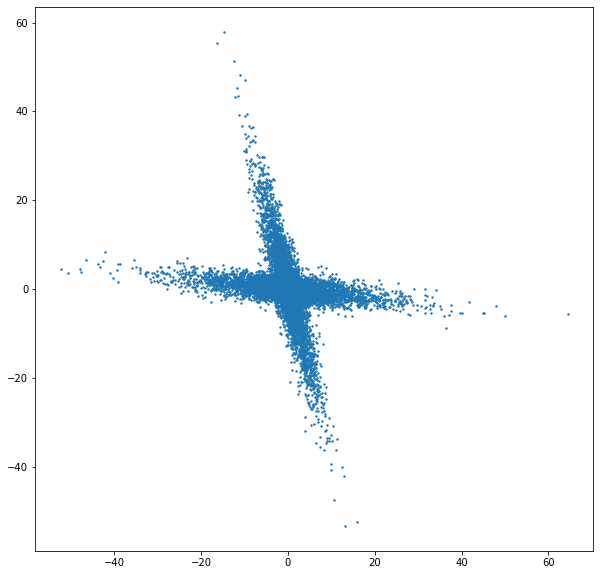

In [9]:
training_model = generate_generative_model(fix_params = True)

with torch.no_grad():
    *_, training_data = training_model.full_generate(10000)
    *_, testing_data = training_model.full_generate(1000)

data = training_data

fig, axes = plt.subplots(1, figsize = (10, 10))
axes.scatter(*data.T[[0, 1]], s = 2)

In [ ]:
from purias_utils.generative.helmholtz.ddc_helmholtz import DDCHelmholtzMachine, DDCHMDataLayer, DDCHMLayer

helmholtz_machine_layers = [
    DDCHMLayer(latent_dim = 1, encoding_dim = 100, lower_encoding_dim = 100, alpha_output_dim = 1, beta_output_dim = 2),              # Bernoulli
    DDCHMLayer(latent_dim = 1, encoding_dim = 100, lower_encoding_dim = 100, alpha_output_dim = 2, beta_output_dim = 2),             # MoG 
    DDCHMLayer(latent_dim = 2, encoding_dim = 100, lower_encoding_dim = 100, alpha_output_dim = 2, beta_output_dim = 6),         # Laplace
    DDCHMDataLayer(data_dim = 2, encoding_dim = 100, sufficient_statistic_dim = 6, higher_encoding_dim = 100)           # Data, with special case for alpha input (equation 36)
]

helmholtz_machine = DDCHelmholtzMachine(
    layers = helmholtz_machine_layers,
    generative_model = training_model   # Initialise to same parameters, as in the paper
)

# As in paper, we freeze these parts of the generative model
for param in helmholtz_machine.generative_model.layers[0].parameters():
    param.requires_grad = False
for param in helmholtz_machine.generative_model.layers[1].parameters():
    param.requires_grad = False

lr_sleep = 0.0001
lr_wake = 0.001
batch_size = 200
num_batches = training_data.shape[0] // batch_size

optim = torch.optim.Adam(helmholtz_machine.parameters(), lr=lr_sleep)

all_recognition_losses = []
all_function_approximation_losses = []
all_wake_gradient_mags = []


for epoch in range(1000):

    for i in range(num_batches):

        ## Sleep phase
        optim.zero_grad()
        sleep_losses = helmholtz_machine.sleep_phase_losses(batch_size)
        sleep_loss = sum(sleep_losses['recognition_losses']) + 0.0000001 * sum(sleep_losses['function_approximation_losses'])
        sleep_loss.backward()
        optim.step()
        all_recognition_losses.append(sum(sleep_losses['recognition_losses']).item())
        all_function_approximation_losses.append(sum(sleep_losses['function_approximation_losses']).item())


        ## Wake phase
        wake_gradients = helmholtz_machine.wake_phase_gradients(training_data[i*batch_size:(i + 1)*batch_size])
        wake_gradient_mag = 0.0

        # As in paper, do not learn the first (2) layer(s)
        for i, wake_gradient in enumerate(wake_gradients[2:], 2):
            avg_gradient = wake_gradient.mean(0)
            wake_gradient_mag += avg_gradient.square().sum().sqrt()
            current_params = helmholtz_machine.generative_model.layers[i].raw_parameter_values().data
            assert avg_gradient.shape == current_params.shape
            helmholtz_machine.generative_model.layers[i].replace_raw_parameters(current_params + (lr_wake * avg_gradient))
        
        all_wake_gradient_mags.append(wake_gradient_mag.item())

    if epoch % 10 == 0:
        print(
            "Epoch", 
            epoch, 
            '\t', sum(all_recognition_losses[-num_batches:])/num_batches, 
            '\t', sum(all_function_approximation_losses[-num_batches:])/num_batches, 
            '\t', sum(all_wake_gradient_mags[-num_batches:])/num_batches
        )

fig, axes = plt.subplots(3)
axes[0].plot(all_recognition_losses, label = 'recognition losses')
axes[0].plot(all_function_approximation_losses, label = 'function approximation losses')
axes[1].plot(all_wake_gradient_mags, label = 'wake gradient magnitudes')
plt.show()

import pdb; pdb.set_trace()


Not working!